In [167]:
'''
This is code for extracting NN features of face image data 
and then fit a linear model to predict attractiveness of a face
Available dataset: TWIN, CHICAGO and MIT
Available NN feature: 'caffeNet','vgg16','vggFace' and 'faceSNN'

BY Linjie Li
Please run this code on guru2 server
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os


# Load image dataset#
Dataset = 'twin' # 'twin', 'chicago' or 'mit'
if Dataset == 'twin':
    imPath = '../../processing/imageProcessing/paddedImages/'
    ext = '.png'
elif Dataset == 'chicago':
    imPath = '../../ChicagoFaceDataset/CFD Version 2.0/CFD 2.0 Images/'
    ext = 'N.jpg'
else:
    imPath = '../../MIT2kFaceDataset/2kfaces/'
    ext = '.jpg'
imList = []
for dirpath, dirnames, filenames in os.walk(imPath):
    for filename in [f for f in filenames if f.endswith(ext)]:
        imList.append(os.path.join(dirpath, filename))
imList.sort()
print len(imList)
print imPath

# Make sure that caffe is on the python path:
caffe_root = '/raid/linjieli/caffe/'
pretrained_model_root = '/raid/linjieli/caffe/'

# run this line one time only!
import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)


import caffe
# Load mean
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# Load the trained net
MODEL = 'caffeNet' #'caffeNet','vgg16','vggFace' or 'faceSNN'

saveFigPath = '../Result/'+Dataset+'/'+MODEL
if not os.path.exists(saveFigPath):
    os.makedirs(saveFigPath)
    
if MODEL == 'vgg16':
    MODEL_FILE = caffe_root +'models/VGG16/VGG_ILSVRC_16_layers_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
elif MODEL == 'caffeNet':
    MODEL_FILE = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
elif MODEL == 'vggFace':
    MODEL_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F.caffemodel'
    MEAN_FILE = caffe_root + 'models/VGGFACE/VGG_mean.binaryproto'
else:
    MODEL = 'faceSNN'
    MODEL_FILE = caffe_root +'models/sraonet/siamese_lecun_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/sraonet/snapshots/sraonet_lecun_gd_sub2_iter_100000.caffemodel'
    
caffe.set_device(1)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
if MODEL != 'faceSNN':
    # subtract the dataset-mean value in each channel
    transformer.set_mean('data', mu)
    print 'featureNum: ',net.params['fc7'][1].data.shape
else:
    print 'featureNum: ',net.params['fc6'][1].data.shape
transformer.set_transpose('data', (2,0,1))
# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255) 
# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))

200
../../processing/imageProcessing/paddedImages/
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
Defining the net!
featureNum:  (4096,)


In [168]:
# read in image list 
def readFile(fName):
    text_file = open(fName, "r")
    lines = text_file.read().split('\n')
    text_file.close()
    return lines

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if MODEL == 'vgg16' or MODEL == 'vggFace':
    featureNum = 4096
    imgeReshape = [224,224]
    featureLayer = 'fc7'
elif MODEL == 'caffeNet':
    featureNum = 4096
    imgeReshape = [227,227]
    featureLayer = 'fc7'
else:
    featureNum = 50
    imgeReshape = [56,46]
    featureLayer = 'fc6'

if Dataset == 'twin':
    features = np.zeros([4,len(imList)/4,featureNum])
    perImNum = len(imList)/4
    img_type_num = {}
    img_type_index = {}
    img_type_list = {}
    type_index = 0
else:
    features = np.zeros([len(imList),featureNum])
totalNum = 0

# print len(imList)
for img in imList:
    imgName = os.path.basename(img)
    if imgName.endswith(('.jpg','.png')):
        input_image = caffe.io.load_image(img)
        net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = net.blobs[featureLayer].data
        if Dataset =='twin':
            img_type = int(imgName[7:-4])/perImNum
            img_index = int(imgName[7:-4])%perImNum
            #print 'img_type:',img_type
            if img_type in img_type_num.keys():
                img_type_num[img_type] = img_type_num[img_type] + 1
                img_type_list[img_type][img_index] = img
            else:
                img_type_num[img_type] = 0
                img_type_list[img_type] = [None]*perImNum
                img_type_index[img_type] = type_index
                type_index +=1
            #print 'img_type_index:',img_type_index[img_type]
            features[img_type_index[img_type],img_type_num[img_type]] = feat.flatten()
        else:
            # need to be further revised!
            features[totalNum] = feat.flatten()
            #print features[totalNum]
        totalNum +=1
    else:
        print img
#print len(img_type_num)
print totalNum
#print img_type_list

200


In [169]:
if Dataset == 'twin':
    featureMat = np.zeros((totalNum,featureNum))
    k = 0
    for i in range(features.shape[0]):
        for j in range(features[i].shape[0]):
            if sum(features[i,j,:])!=0:
                featureMat[k,:] = features[i,j,:]
                k +=1
else:
    featureMat = features
#print featureMat

In [170]:
from sklearn.decomposition import PCA as sklearnPCA
if MODEL != 'faceSNN':
    explained_variance = 0.99
    #explained_variance = 50
else:
    explained_variance = featureNum

sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
feature_transf = sklearn_pca.fit_transform(featureMat)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, feature_transf.shape[1])

The number of PCs needed to retain 0.990 variance is 153.


In [171]:
print feature_transf.shape

(200, 153)


In [172]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
ratingPath = '../Result/'+Dataset+'/meanRating.csv'
mean_rating = pd.read_csv(ratingPath,index_col = 0).as_matrix()[:,0].tolist()
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)

baseLine = mean_rating.mean()
print 'mean rating: ', baseLine
# cross validation to determine the number of features
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
                       feature_transf, mean_rating, test_size=0.2, random_state=0)
corrList = []
varList = []
mseList = []
if MODEL != 'faceSNN':
    numFeature = [40,50,60,65,70,75,80,90,100,120,150,200,250,300,350]
else:
    numFeature = [10,20,30,40,50]
for numF in numFeature:
    X_train_hat = X_train[:,:numF]
#     print X_train_hat.shape
#     print y_train.shape
    X_test_hat = X_test[:,:numF]
    # Do linear regression on feature_arr and mean_rating
    regr = linear_model.Ridge(fit_intercept=True)
    regr.fit(X_train_hat, y_train)
    predicted_rating = regr.predict(X_test_hat)
    #rectified_rating = np.around(predicted_rating, decimals=0)
    # Calculate the mean square error
    MSE = np.mean((predicted_rating - y_test) ** 2)
    mseList.append(MSE)
    
    # Returns the coefficient of determination R^2 of the prediction.
    '''
    The coefficient R^2 is defined as (1 - u/v), 
    where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
    Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
    A constant model that always predicts the expected value of y, 
    disregarding the input features, would get a R^2 score of 0.0.
    '''
    variance_score = regr.score(X_test_hat, y_test)
    varList.append(variance_score)
    
    # Calculate the correlation between prediction and actual rating.
    cor = np.corrcoef(predicted_rating, y_test)
    corrList.append(cor[0,1])

print 'Correlation: ', max(corrList)
print 'num of features: ',numFeature[np.argmax(corrList)]
print 'R^2 score: ',max(varList)
print 'num of features: ',numFeature[np.argmax(varList)]
print 'MSE: ',min(mseList)
print 'num of features: ',numFeature[np.argmin(mseList)]
optNumFea = numFeature[np.argmax(corrList)]
X_train_hat = X_train[:,:optNumFea]
X_test_hat = X_test[:,:optNumFea]

mean rating:  3.75657605178
Correlation:  0.27099898547
num of features:  120
R^2 score:  -0.190732238889
num of features:  40
MSE:  1.0797022943
num of features:  40


Intercept:  3.84631783601
Residual sum of squares: 0.19
Variance score is: 0.78
Correlation is: 0.89


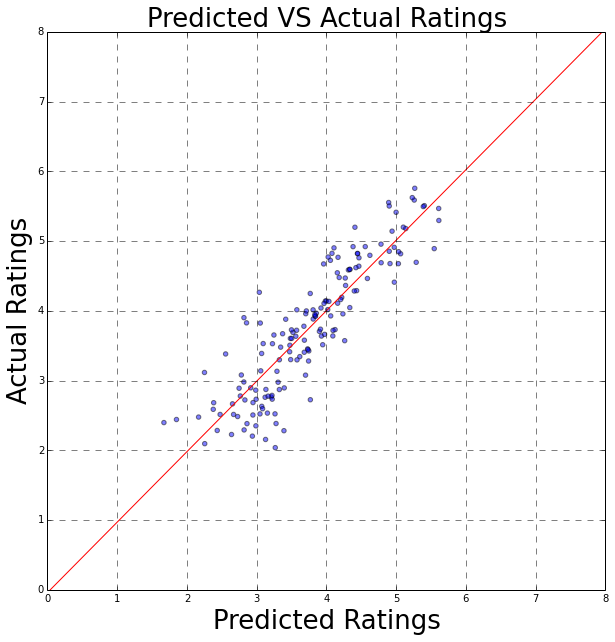

In [173]:
# Do linear regression on feature_arr and mean_rating
regr = linear_model.Ridge(fit_intercept=True)
regr.fit(X_train_hat, y_train)
predicted_rating = regr.predict(X_train_hat)
#rectified_rating = np.around(predicted_rating, decimals=0)

# The coefficients
#print 'Coefficients: ', regr.coef_[0:10]
print 'Intercept: ', regr.intercept_
# Calculate the mean square error
MSE = np.mean((predicted_rating - y_train) ** 2)
print 'Residual sum of squares: %.2f' % MSE

# Calculate how much variance is explained
variance_score = regr.score(X_train_hat, y_train)
print 'Variance score is: %.2f' % variance_score

# Calculate the correlation between prediction and actual rating.
cor = np.corrcoef(predicted_rating, y_train)
print 'Correlation is: %.2f' %cor[0, 1]

fName = saveFigPath+'/'+MODEL+'_training.txt'
with open(fName,'w') as f:
    f.write('Training Accuracy\n')
    f.write('Number of features: %d'%X_train_hat.shape[1] +'\n')
    f.write('Residual sum of squares: %.2f' %MSE+'\n')
    f.write('Variance score is: %.2f' %variance_score+'\n')
    f.write('Correlation between predicted ratings and actual ratings is: %.4f'\
            %cor[0,1]+'\n')  
# # Plot prediction vs actual rating.
x = predicted_rating
y = y_train
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5)
ax.set_xlim((0, 8))
ax.set_ylim((0, 8))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')
m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-r')
plt.xlabel('Predicted Ratings',fontsize = 26)
plt.ylabel('Actual Ratings',fontsize = 26)
plt.title('Predicted VS Actual Ratings',fontsize = 26)
plt.savefig(saveFigPath+'/'+MODEL+'_predVsActual.png')

In [174]:
# k-fold#
from sklearn.cross_validation import KFold
imgNum = feature_transf.shape[0]
foldNum = 20
kf = KFold(imgNum, n_folds=foldNum, shuffle=True)
print(kf)

corrList = []
varList = []
mseList = []
feature_new = feature_transf[:,:optNumFea]
for train_index, test_index in kf:
    feature_train, feature_test = feature_new[train_index], feature_new[test_index]
    rating_train, rating_test = mean_rating[train_index], mean_rating[test_index]
    
    # Do linear regression on feature_arr and mean_rating
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(feature_train, rating_train)
    predicted_rating = regr.predict(feature_test)

    # Calculate the mean square error
    MSE = np.mean((predicted_rating - rating_test) ** 2)
    mseList.append(MSE)
    
    # Returns the coefficient of determination R^2 of the prediction.
    variance_score = regr.score(feature_test, rating_test)
    varList.append(variance_score)
    
    # Calculate the correlation between prediction and actual rating.
    cor = np.corrcoef(predicted_rating, rating_test)
    corrList.append(cor[0,1])
    
print 'Residual sum of squares: %.2f' % (sum(mseList)/foldNum)
print 'Variance score is: %.2f' % (sum(varList)/foldNum)
print 'Correlation between predicted ratings and actual ratings is: %.4f'%(sum(corrList)/foldNum)

fName = saveFigPath+'/'+MODEL+'_kFold.txt'
with open(fName,'w') as f:
    f.write('Number of folds: %d' % foldNum +'\n')
    f.write('Residual sum of squares: %.2f' % (sum(mseList)/foldNum)+'\n')
    f.write('Variance score is: %.2f' % (sum(varList)/foldNum)+'\n')
    f.write('Correlation between predicted ratings and actual ratings is: %.4f'\
            %(sum(corrList)/foldNum)+'\n')

sklearn.cross_validation.KFold(n=200, n_folds=20)
Residual sum of squares: 3.67
Variance score is: -4.72
Correlation between predicted ratings and actual ratings is: 0.0121


In [175]:
import pickle
np.savetxt(saveFigPath+'/feature_pca_atrr.csv', feature_new, delimiter=',')
#np.savetxt(saveFigPath+'/feature_atrr.csv',featureMat,delimiter = ',')
if Dataset == 'twin':
    img_index_name_map = dict()
    for key in img_type_list.keys():
        img_index_name_map[img_type_index[key]] = img_type_list[key]
    with open('../Result/'+Dataset+'/attr_imgIndex_name.pickle', 'wb') as handle:
        pickle.dump(img_index_name_map, handle)